## COMP537 HW3

Author: Yasemin Savaş\
Date: 11.05.2022

### Libraries

In [29]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import KFold, GridSearchCV
from sklearn_evaluation import plot
import seaborn as sns
import warnings
from sklearn.exceptions import DataConversionWarning
import pickle
from math import pi

pd.options.mode.chained_assignment = None
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

### Part A

Load and plot the data in the input file.\
The plot should be a 2D plot of the input points visualized in accordance with their 2D coordinates and colors.

In [2]:
x = []
y = []
colors = []

with open('/Users/yaseminsavas/Desktop/Input.txt') as f:
    lines = f.readlines()
    
    for line in lines:
        
        line_v2 = line.split(",")
        
        x.append(float(line_v2[0]))
        y.append(float(line_v2[1]))
        
        if int(line_v2[2][:-1]) == 1:
            colors.append("red")
        elif int(line_v2[2][:-1]) == 0:
            colors.append("black")

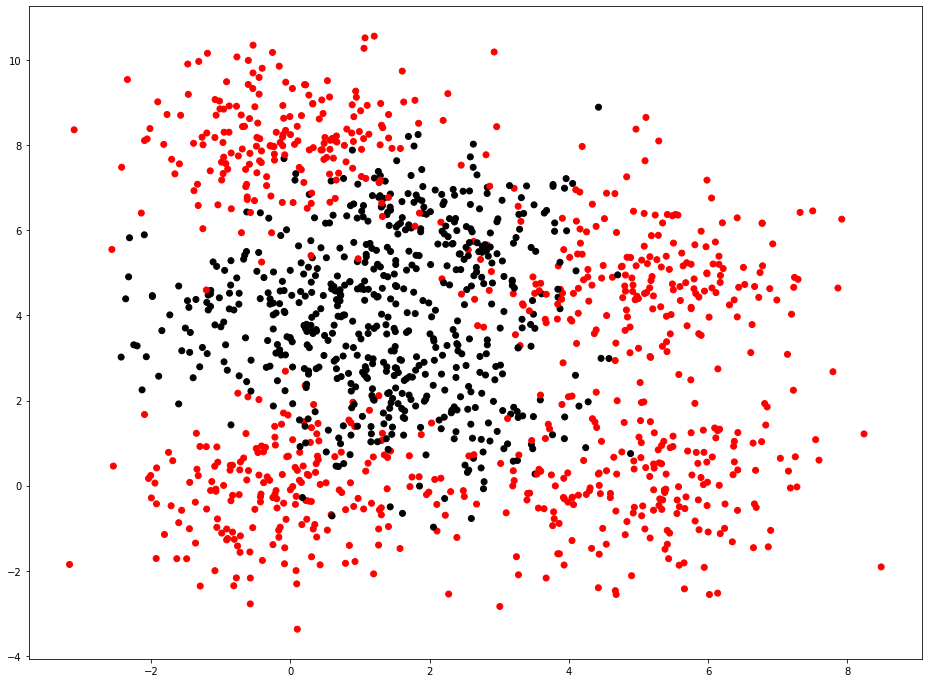

In [3]:
plt.rcParams["figure.figsize"] = (16,12)
plt.scatter(x,y, c=colors)
plt.show()

Manually draw decision boundaries that separate the red and black points from each other.\
The boundaries can be non-linear.

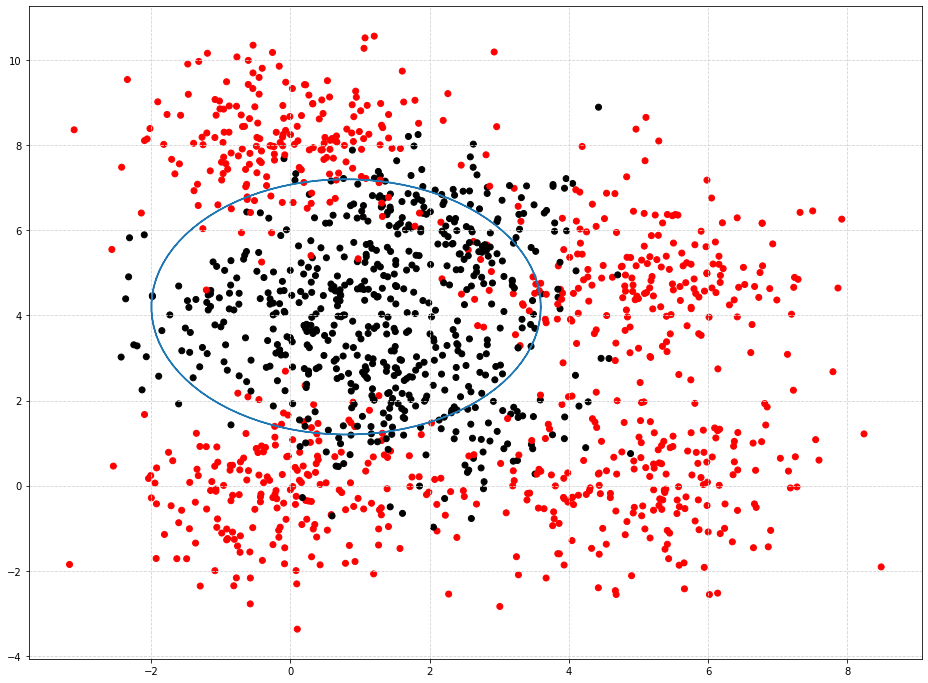

In [30]:
# I couldn't draw the non-linear boundary but add an ellipse.
t = np.linspace(0, 4*pi, 100)
plt.plot( 0.8 +1.4 *np.cos(t)*2 , 4.2+1.5*np.sin(t)*2 )
plt.grid(color='lightgray',linestyle='--')

plt.rcParams["figure.figsize"] = (16,12)
plt.scatter(x,y, c=colors)

### Part C

Manual IF/ELSE Classifier

Once you are happy with your classifier, test your classifier with the input file. Document the accuracy of your classifier (Number of correctly labeled points / Number of all points) along with a plot of the input file points. Plot the points according to your color labels instead of the original color labels.


In [5]:
pred_colors = []

with open('/Users/yaseminsavas/Desktop/Input.txt') as f:
    lines = f.readlines()
    
    for line in lines:
        
        line_v2 = line.split(",")
        
        if float(line_v2[0]) >= -2.5 and float(line_v2[0]) <= 3.5: # x-axis range
            if float(line_v2[1]) >= 1.5 and float(line_v2[1]) <= 7: # y-axis range
                pred_colors.append("black")
            else:
                pred_colors.append("red")
                    
        else:
            pred_colors.append("red")

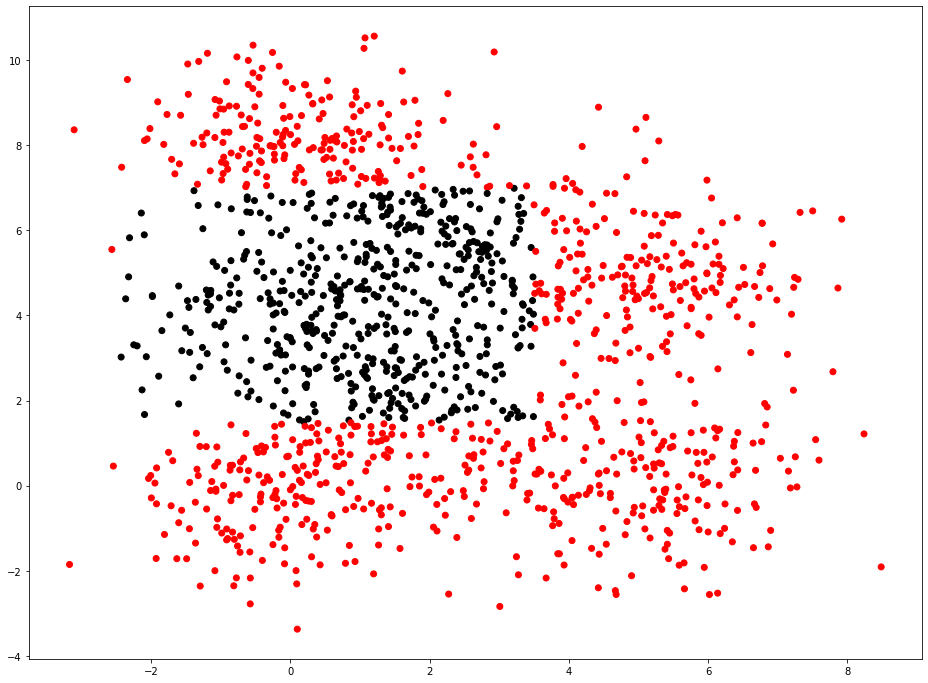

In [6]:
plt.rcParams["figure.figsize"] = (16,12)
plt.scatter(x,y, c=pred_colors)
plt.show()

In [7]:
data = pd.DataFrame({"true":colors,"pred":pred_colors})
accuracy = ((data.true=="red") & (data.pred == "red"))|((data.true=="black") & (data.pred == "black")).astype(int)

In [8]:
print("Accuracy is:", accuracy.sum()/data.shape[0])

Accuracy is: 0.87


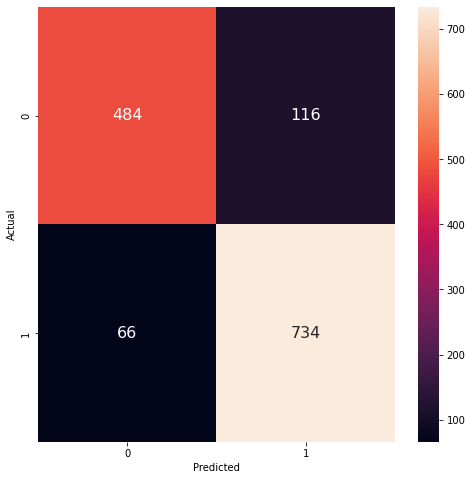

In [9]:
cm = confusion_matrix(data["true"],data["pred"])
fig, ax = plt.subplots(figsize=(8,8))

ax = sns.heatmap(cm, annot=True, annot_kws={"size": 16},cbar=True,fmt='g')

plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

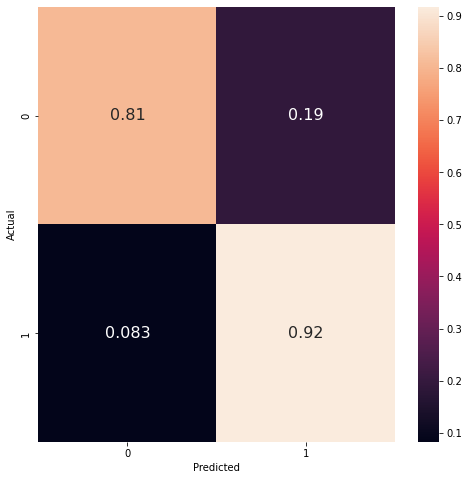

In [10]:
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalization

fig, ax = plt.subplots(figsize=(8,8))

ax = sns.heatmap(cmn, annot=True, annot_kws={"size": 16},cbar=True)

plt.ylabel('Actual')
plt.xlabel('Predicted')

plt.show()

### Part D

Using libsvm (http://www.csie.ntu.edu.tw/~cjlin/libsvm/) and MATLAB, train 3 different SVMs for the input file. Train the first SVM using a linear kernel, the second
SVM using a radial basis function (RBF) kernel and the third using a polynomial kernel. For all SVMs:
1- Use 5-fold cross-validation to separate the input file into training/validation and test data. Training data is used for calculating the support vectors of a support vector model. Validation data is used for finding the optimum cost and gamma parameter values before training a model. Test data is used for measuring the actual predictive power of a model.
2- Use 5-fold cross-validation to further separate the training/validation data into training and validation data. Plot the 2D heatmap matrix that shows the cross-validation accuracy value for each cost and gamma parameter pair you have tried during grid search. The ranges for cost and gamma parameters should be as follows: (-1 ≤ log2cost ≤ 10) and (-10 ≤ log2gamma ≤ 1).

In [11]:
data_X1 = []
data_X2 = []
data_y = []

with open('/Users/yaseminsavas/Desktop/Input.txt') as f:
    lines = f.readlines()
   
    for line in lines:
        line_v2 = line.split(",")
        data_X1.append(float(line_v2[0]))
        data_X2.append(float(line_v2[1]))
        data_y.append(int(line_v2[2][:-1]))
        
# our main data
data = pd.DataFrame({"x-coordinate":data_X1,"y-coordinate":data_X2,"target":data_y})
data["id"] = data.index

### Function for cross validation & grid search

In [12]:
def cross_validation(X,y,model,param_grid):
    
    cv = KFold(shuffle=False,n_splits=5) # Default n_splits = 5 & shuffle = False 
    cv_scores = np.empty(5)
    counter = 0
    
    # This is for separating (train/validation) & test
    for idx2, (train_idx, test_idx) in enumerate(cv.split(X,y)):
        x_train, x_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        y_test["id"] = y_test.index
        y_train["id"] = y_train.index

        x_test["id"] = x_test.index
        x_train["id"] = x_train.index

        drop_ix = y_train.index.intersection(y_test.index).to_list()

        y_test = y_test[~y_test["id"].isin(drop_ix)]
        x_test = x_test[~x_test["id"].isin(drop_ix)]

        y_train = y_train.drop(columns=["id"])
        x_train = x_train.drop(columns=["id"])
        y_test = y_test.drop(columns=["id"])
        x_test = x_test.drop(columns=["id"])
        
        # This for is for separating train & validation
        cv_scores2 = np.empty(5)
        counter2 = 0
            
        # Grid Search
        grid = GridSearchCV(model, param_grid, cv = 5)
        grid.fit(x_train, y_train)
        
        preds = grid.predict(x_test)
        cv_scores[idx2] = accuracy_score(y_test, preds)
        counter += 1
        
        #print(f"Accuracy in epoch {counter} for test set:",cv_scores[idx2])
        #print(" ")
    
    #print(cv_scores)
    #print("Overall mean accuracy in test set:",np.mean(cv_scores))
    #print(" ")
    
    plot.grid_search(grid.cv_results_, change=("C", "gamma"))
    
    return grid, cv_scores

In [13]:
# The ranges for cost and gamma parameters should be as follows: (-1 ≤ log2cost ≤ 10) and (-10 ≤ log2gamma ≤ 1).

param_grid_rbf = {'C': [0.0009,0.5,1,10,100,1024],
                  'gamma': [0.005,0.1,1,2],
                  'kernel': ['rbf']}

param_grid_linear = {'C': [0.0009,0.5,1,10,100,1024],
              'gamma': [0.005,0.1,1,2],
              'kernel': ['linear']}

param_grid_poly = {'C': [0.0009,0.5,1,10,100,1024],
              'gamma': [0.005,0.1,1,2],
              'kernel': ['poly']}

### 1. Linear Kernel

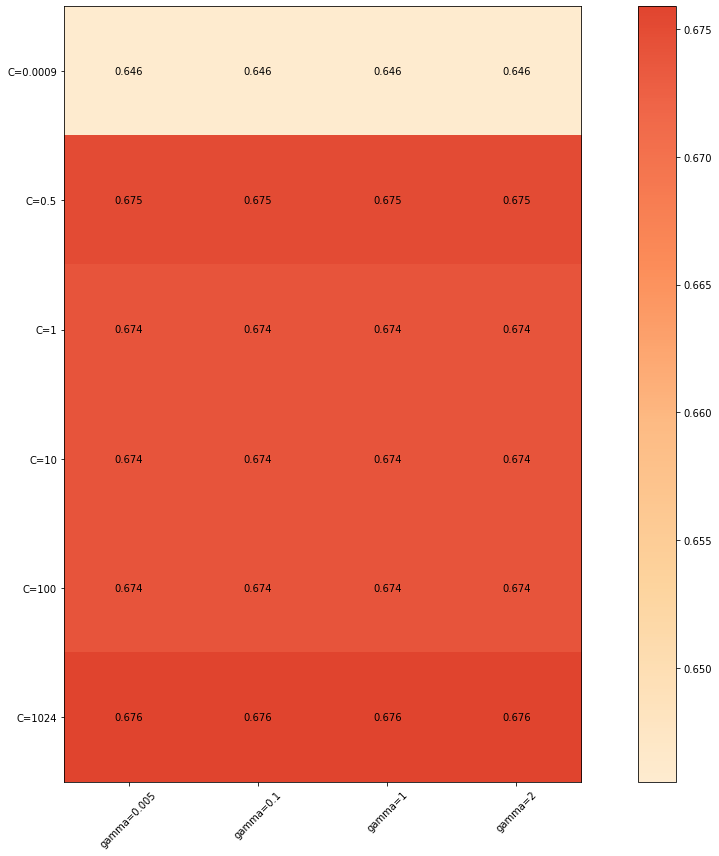

In [22]:
linear_svc = SVC(kernel='linear') 
linear_model, cv_scores_linear = cross_validation(data[["x-coordinate","y-coordinate"]],
                                                  pd.DataFrame(data["target"]),
                                                  linear_svc,param_grid_linear)

In [23]:
print("Number of support vectors for each class:",len(linear_model.best_estimator_.n_support_))
print("best params:",linear_model.best_params_)
print("best estimator:",linear_model.best_estimator_)

Number of support vectors for each class: 2
best params: {'C': 1024, 'gamma': 0.005, 'kernel': 'linear'}
best estimator: SVC(C=1024, gamma=0.005, kernel='linear')


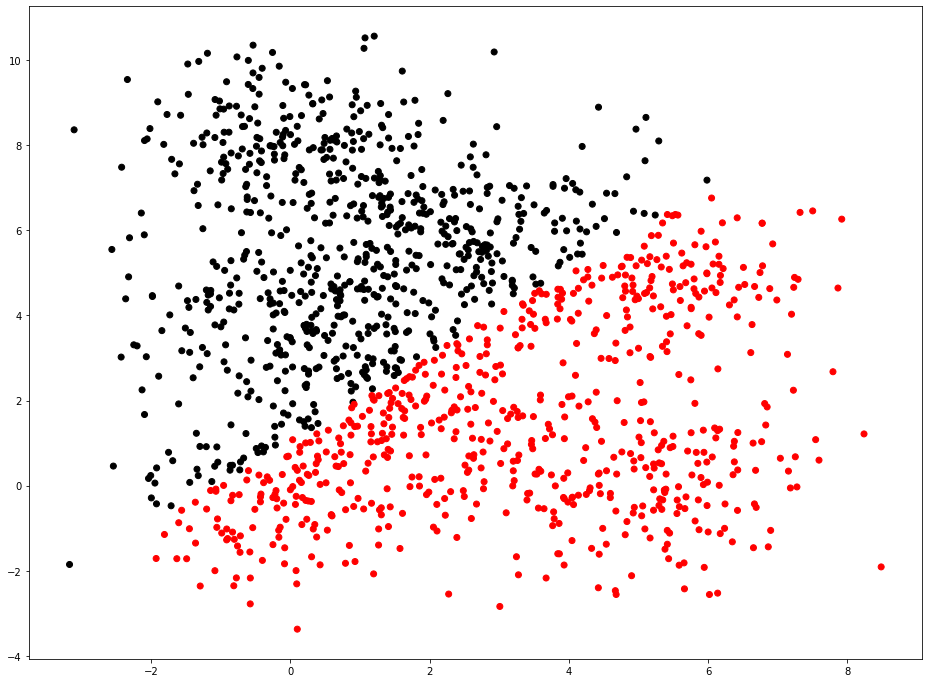

In [24]:
preds_linear = linear_model.best_estimator_.predict(data[["x-coordinate","y-coordinate"]])
pred_colors = np.where(preds_linear==1,'red','black')
plt.rcParams["figure.figsize"] = (16,12)
plt.scatter(x,y, c=pred_colors)
plt.show()

In [25]:
print(accuracy_score(data["target"], preds_linear))

0.6721428571428572


In [26]:
file_to_store = open("linear_model.pickle", "wb")
pickle.dump(linear_model.best_estimator_, file_to_store)
file_to_store.close()

### 2. RBF Kernel

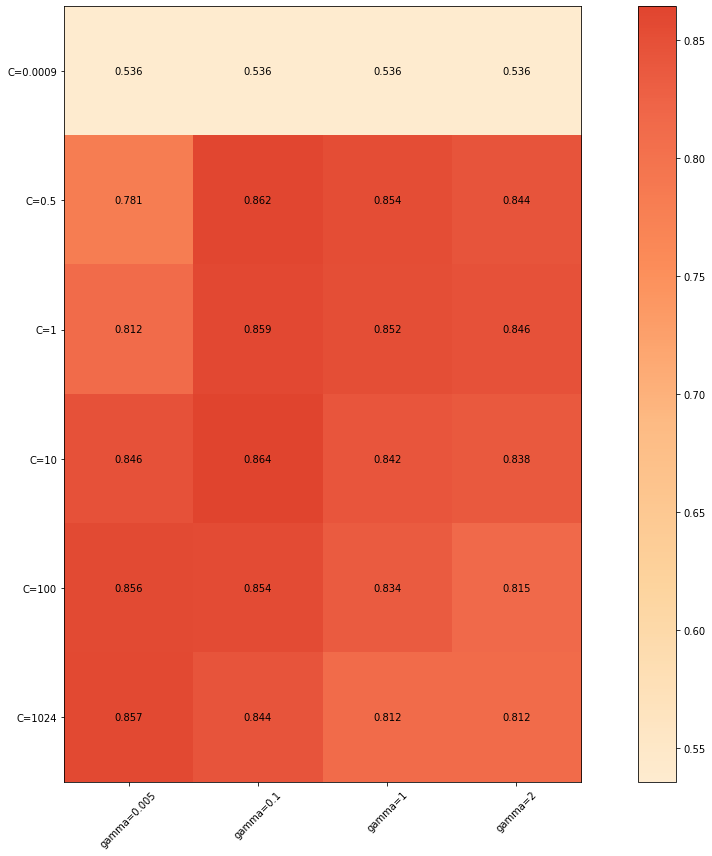

In [14]:
rbf_svc = SVC(kernel='rbf') 
rbf_model, cv_scores_rbf = cross_validation(data[["x-coordinate","y-coordinate"]],
                                            pd.DataFrame(data["target"]),
                                            rbf_svc,param_grid_rbf)

In [15]:
print("Number of support vectors for each class:",len(rbf_model.best_estimator_.n_support_))
print("best params:",rbf_model.best_params_)
print("best estimator:",rbf_model.best_estimator_)

Number of support vectors for each class: 2
best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
best estimator: SVC(C=10, gamma=0.1)


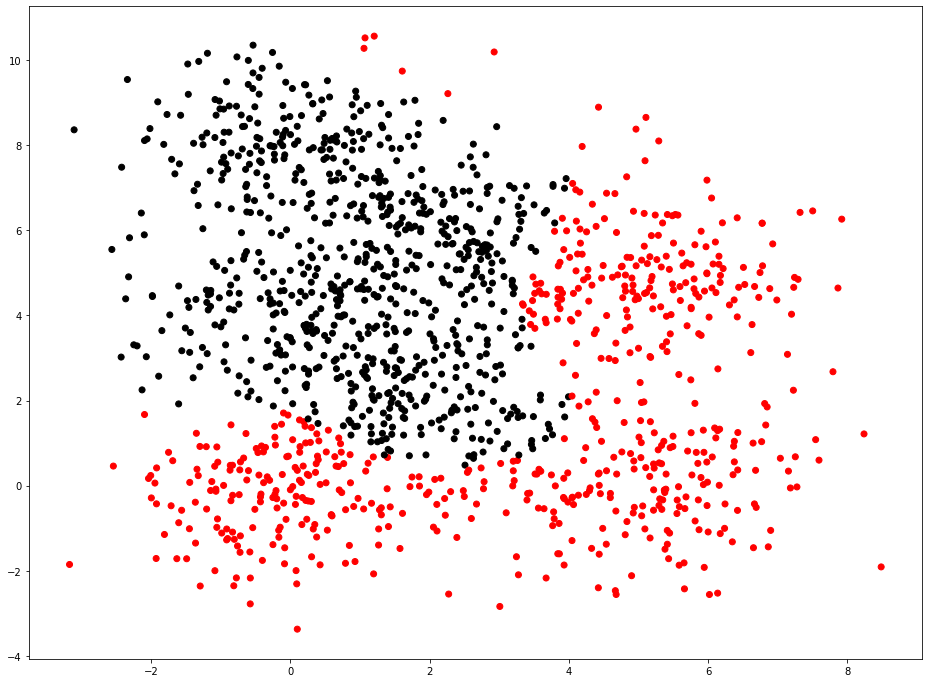

In [16]:
preds_rbf = rbf_model.best_estimator_.predict(data[["x-coordinate","y-coordinate"]])
pred_colors = np.where(preds_rbf==1,'red','black')
plt.rcParams["figure.figsize"] = (16,12)
plt.scatter(x,y, c=pred_colors)
plt.show()

In [17]:
print(accuracy_score(data["target"], preds_rbf))

0.7885714285714286


In [21]:
file_to_store = open("rbf_model.pickle", "wb")
pickle.dump(rbf_model.best_estimator_, file_to_store)
file_to_store.close()

### 3. Polynomial Kernel

In [31]:
# I used this smaller subset because the regular one takes too much time. 
# However, this takes too much time as well..
param_grid_poly = {'C': [0.5,1,10],
              'gamma': [0.005,0.1,1,2],
              'kernel': ['poly']}

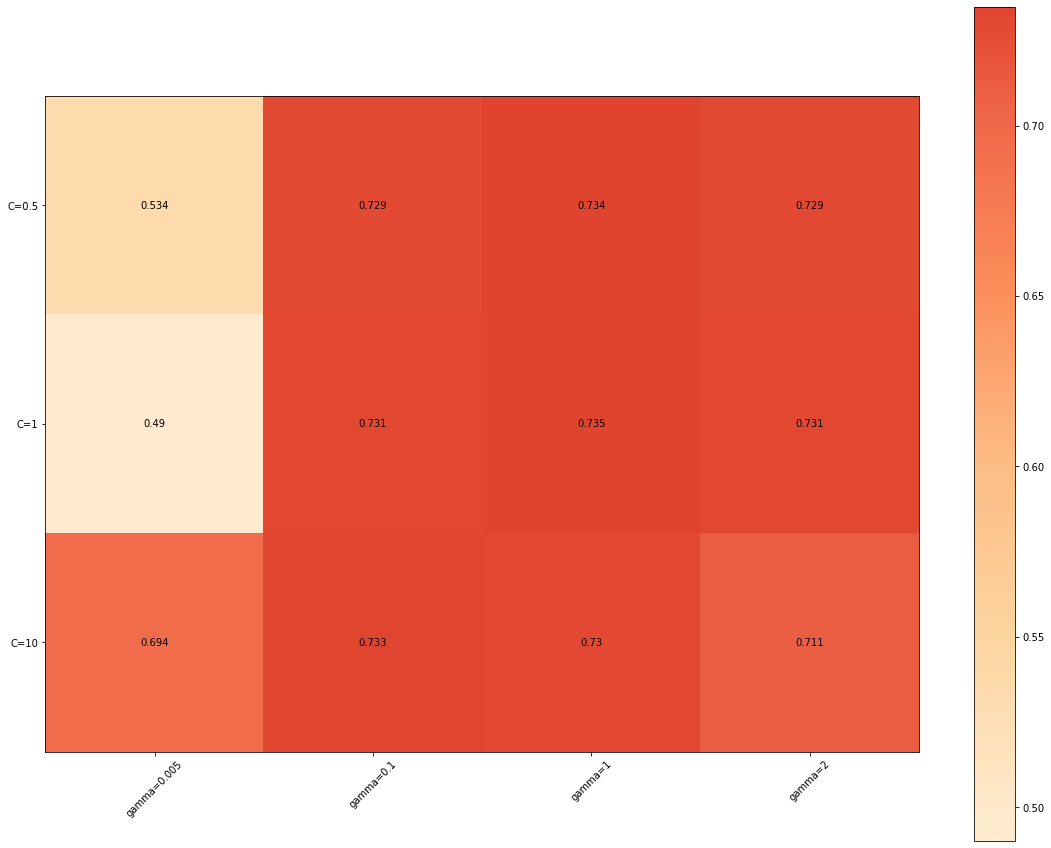

In [32]:
poly_svc = SVC(kernel='poly') 
polynomial_model, cv_scores_polynomial = cross_validation(data[["x-coordinate","y-coordinate"]],
                                                          pd.DataFrame(data["target"]),
                                                          poly_svc,param_grid_poly)

In [33]:
print("Number of support vectors for each class:",len(polynomial_model.best_estimator_.n_support_))
print("best params:",polynomial_model.best_params_)
print("best estimator:",polynomial_model.best_estimator_)
print(" ")

Number of support vectors for each class: 2
best params: {'C': 1, 'gamma': 1, 'kernel': 'poly'}
best estimator: SVC(C=1, gamma=1, kernel='poly')
 


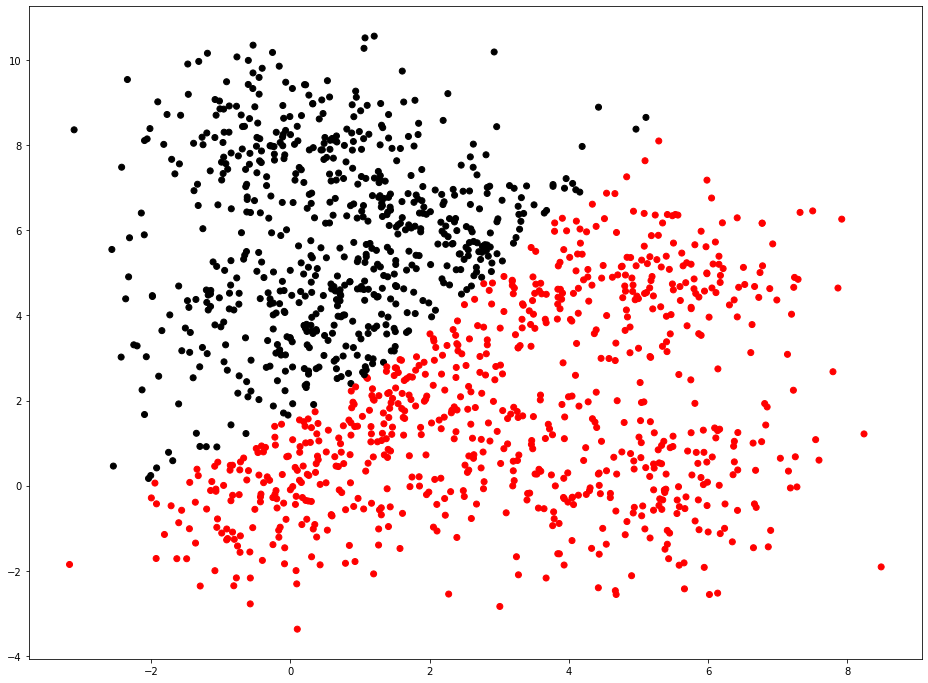

In [34]:
preds_poly = polynomial_model.best_estimator_.predict(data[["x-coordinate","y-coordinate"]])
pred_colors = np.where(preds_poly==1,'red','black')
plt.rcParams["figure.figsize"] = (16,12)
plt.scatter(x,y, c=pred_colors)
plt.show()

In [35]:
print(accuracy_score(data["target"], preds_poly))

0.6857142857142857


In [36]:
file_to_store = open("polynomial_model.pickle", "wb")
pickle.dump(polynomial_model.best_estimator_, file_to_store)
file_to_store.close()

### Best SVM Classifier

RBF

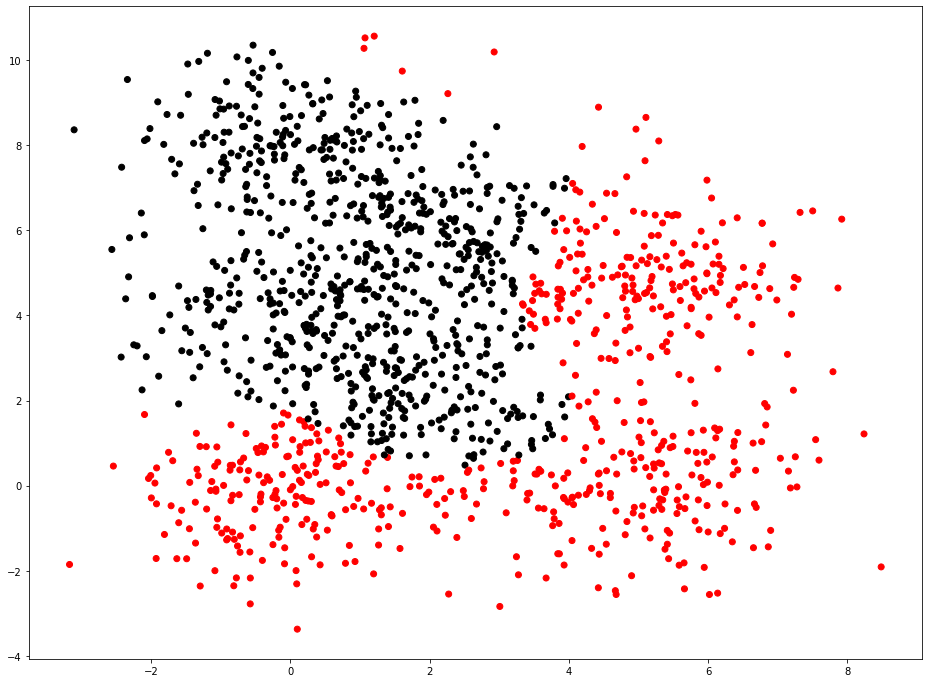

In [37]:
preds_rbf = rbf_model.best_estimator_.predict(data[["x-coordinate","y-coordinate"]])
pred_colors = np.where(preds_rbf==1,'red','black')
plt.rcParams["figure.figsize"] = (16,12)
plt.scatter(x,y, c=pred_colors)
plt.show()

In [38]:
print(accuracy_score(data["target"], preds_rbf))

0.7885714285714286
